In [2]:
import numpy as np
import cv2
import json
import os
import time
import tqdm
import requests 
import matplotlib.pyplot as plt
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

# change this data path for your own
DATA_PATH = "/home/kirill/data/zennolab_tasks"

/home/kirill/.conda/envs/zennolab_testtask/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Main functions, metrics

In [3]:
def euclidean_distance(pred_coords, true_coords):
    return np.sqrt(np.sum(pred_coords - true_coords, axis=1) ** 2)

def mean_accuracy(pred_coords, true_coords, eps=0.1):
    assert pred_coords.shape[0] == true_coords.shape[0]
    
    d = euclidean_distance(pred_coords, true_coords)
    return np.sum((d < eps).astype(int)) / pred_coords.shape[0]
    
    
def read_dataset(datapath):
    dataset = dict()
    for d in os.listdir(datapath):
        dataset[d] = []
        
        task_path = os.path.join(datapath, d)
        ids = [i.split('.json')[0] for i in os.listdir(task_path) if '.json' in i]
        for i in ids:
            img_path = os.path.join(task_path, i + '.jpg')
            json_path = os.path.join(task_path, i + '.json')
            
            # check that image exists and that json isnt empty
            if not os.path.exists(img_path) or os.stat(json_path).st_size == 0:
                continue
            else:
                # read json and check that there are coordinates in json
                f = open(json_path)
                jsn = json.load(f)
                f.close()
                
                if len(jsn) == 0:
                    continue

            # get center coordinate 
            coord = (jsn[0]["x"], jsn[0]["y"])
            
            dataset[d].append({
                "img_path": img_path,
                "coords_xy": coord
            })
            
    return dataset

# EDA

In [5]:
d = read_dataset(DATA_PATH)

In [44]:
print("All tasks:")
print(list(d.keys()))

All tasks:
['the_center_of_the_teddy_bear_nose', 'the_center_of_the_seahorses_head', 'squirrels_tail', 'the_center_of_the_koalas_nose', 'squirrels_head', 'the_center_of_the_gemstone', 'the_center_of_the_owls_head']


In [47]:
print("Number of images:\n")

overall_num_imgs = 0
for tn, ts in d.items():
    overall_num_imgs += len(ts)
    
    print(f"{tn}, images number: {len(ts)}")
print(f"\nOverall, images number: {overall_num_imgs}")

Number of images:

the_center_of_the_teddy_bear_nose, images number: 4309
the_center_of_the_seahorses_head, images number: 4234
squirrels_tail, images number: 1121
the_center_of_the_koalas_nose, images number: 3983
squirrels_head, images number: 1512
the_center_of_the_gemstone, images number: 4188
the_center_of_the_owls_head, images number: 1910

Overall, images number: 21257


Point visualization:



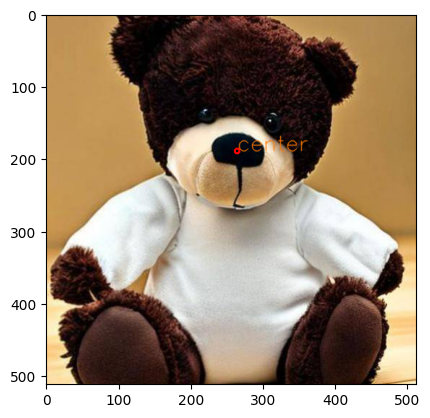

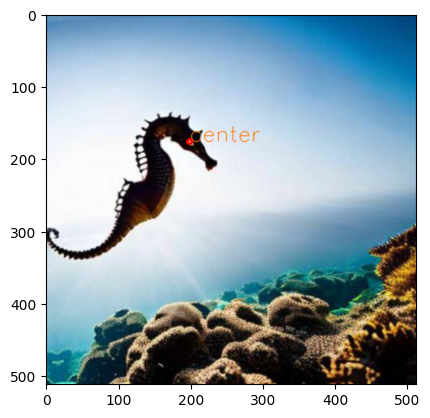

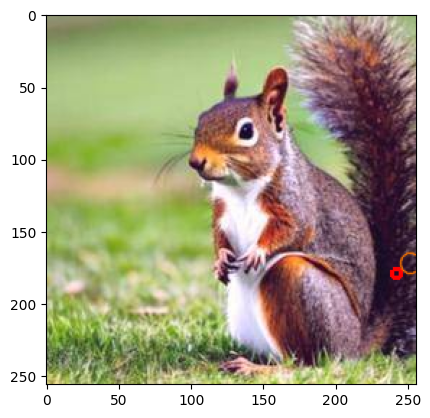

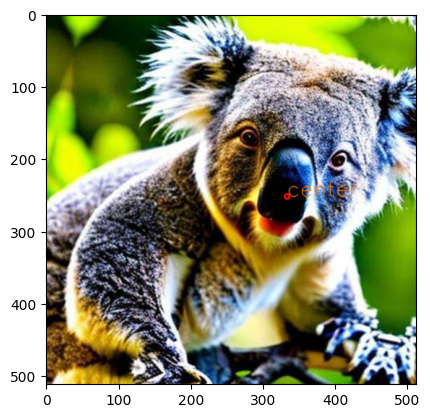

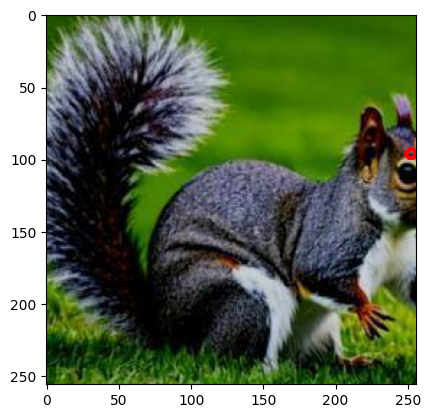

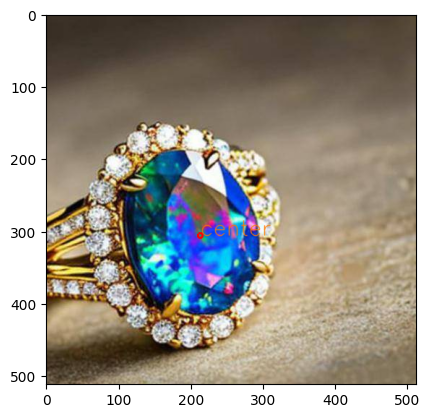

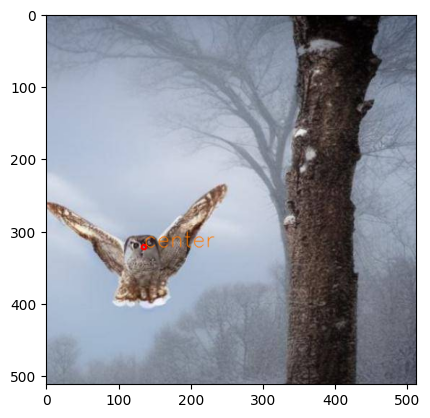

In [68]:
print("Point visualization:\n")

for i, k in enumerate(d.keys()):
    image_path = d[k][0]["img_path"]
    coords_xy = d[k][0]["coords_xy"]
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    cx, cy = int(coords_xy[0] * image.shape[1]), int(coords_xy[1] * image.shape[0])
    image = cv2.circle(image, (cx, cy), 3, (255, 0, 0), 2)
    image = cv2.putText(image, "center", (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 120, 0), 1, cv2.LINE_AA)
    
    plt.imshow(image)
    plt.show()

# Solution

In [4]:
class ModelOwlvitWrapper():
    def __init__(self, model_name="google/owlvit-base-patch32", thr=0.001):
        self.processor = OwlViTProcessor.from_pretrained(model_name)
        self.model = OwlViTForObjectDetection.from_pretrained(model_name)
        self.model.eval()
        self.thr = thr
        
    def __call__(self, image, query, normalize=True):
        inputs = self.processor(text=[query], images=image, return_tensors="pt")
        with torch.no_grad():
            o = model.model(**inputs)
        target_sizes = torch.Tensor([image.shape[::-1][1:]])
        results = model.processor.post_process_object_detection(outputs=o, threshold=self.thr, target_sizes=target_sizes)
        
        scores = results[0]["scores"].numpy()
        top_ind_score = np.argmax(scores)
        
        bbox = results[0]["boxes"][top_ind_score].numpy()
        center_coords = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]
        
        
        if normalize:
            center_coords = [center_coords[0] / image.shape[1], center_coords[1] / image.shape[0]]
        
        return center_coords

In [ ]:
# FOR GPU RUNTIME

# class ModelOwlvitWrapper():
#     def __init__(self, model_name="google/owlvit-base-patch32", thr=0.001):
#         self.processor = OwlViTProcessor.from_pretrained(model_name)
#         self.model = OwlViTForObjectDetection.from_pretrained(model_name)
#         self.model.to('cuda:0')
#         self.model.eval()
#         self.thr = thr

#     def __call__(self, image, query, normalize=True):
#         inputs = self.processor(text=[query], images=image, return_tensors="pt")

#         inputs = {k: v.to('cuda:0') for k, v in inputs.items()}

#         with torch.no_grad():
#             o = model.model(**inputs)
#         target_sizes = torch.Tensor([image.shape[::-1][1:]])
#         target_sizes_gpu = torch.Tensor([image.shape[::-1][1:]]).to('cuda:0')
#         results = model.processor.post_process_object_detection(outputs=o, threshold=self.thr, target_sizes=target_sizes_gpu)

#         results = [{k: v.to('cpu') for k, v in results[0].items()}]

#         scores = results[0]["scores"].numpy()
#         top_ind_score = np.argmax(scores)

#         bbox = results[0]["boxes"][top_ind_score].numpy()
#         center_coords = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]


#         if normalize:
#             center_coords = [center_coords[0] / image.shape[1], center_coords[1] / image.shape[0]]

#         return center_coords

In [ ]:
d = read_dataset(DATA_PATH)

model = ModelOwlvitWrapper()

In [ ]:
overall_predicts, overall_labels = [], []
timer = 0
for task_name, samples in d.items():
    predicts, labels = [], []
    for i, sample in tqdm.tqdm(enumerate(samples)):
        image_path = sample["img_path"]
        coords_xy = sample["coords_xy"]
        
        # read image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # predict center
        start_time = time.time()
        centers_xy = model(image, task_name)
        timer += (time.time() - start_time)
        
        predicts.append(centers_xy)
        labels.append(coords_xy)
        
        if i >= 100:
            break
            
    overall_predicts += predicts
    overall_labels += labels
    
    # print metrics for task
    predicts = np.array(predicts)
    labels = np.array(labels)
    print("-" * 30)
    print(f"Task: {task_name}")
    print("Mean accuracy: ", mean_accuracy(predicts, labels))
    print("Mean euclidean distance: ", np.mean(euclidean_distance(predicts, labels)))
    
# print overall metrics
overall_predicts = np.array(overall_predicts)
overall_labels = np.array(overall_labels)
print(f"\n\nOverall metrics:")
print("Mean accuracy: ", mean_accuracy(overall_predicts, overall_labels))
print("Mean euclidean distance: ", np.mean(euclidean_distance(overall_predicts, overall_labels)))
print("Inference time per sample (ms): ", timer * 1000 / sum([len(i) for i in d.values()]))

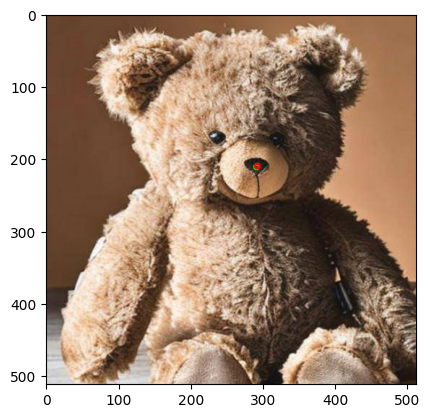

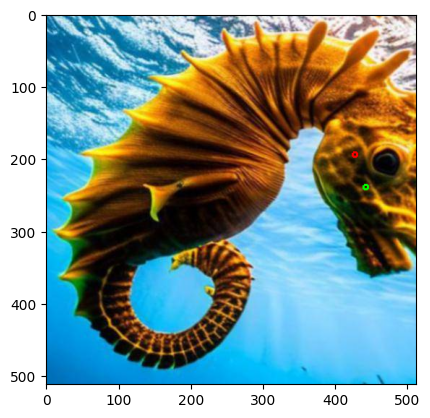

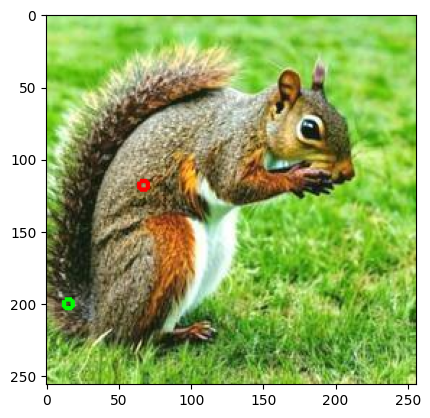

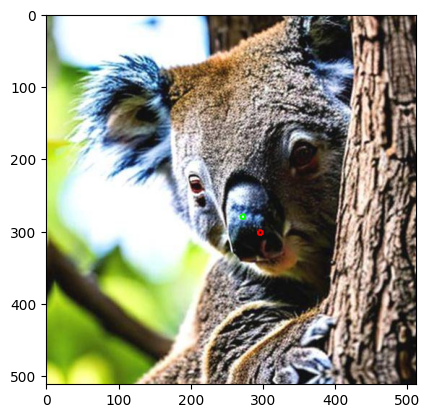

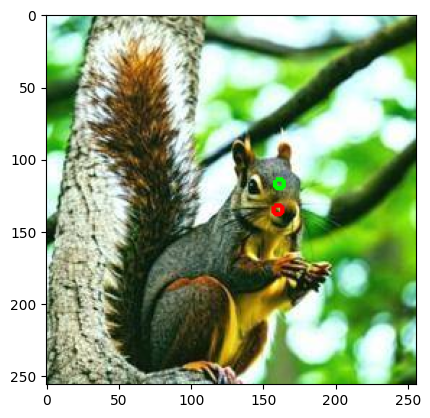

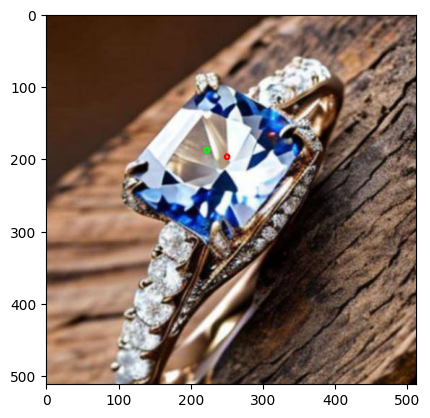

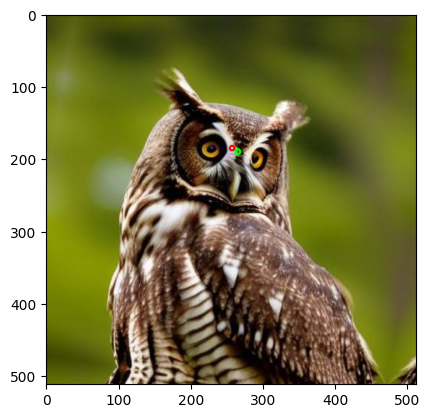

In [181]:
# visualize predictions and labels

for task_name, samples in d.items():
    image_path = samples[5]["img_path"]
    coords_xy = samples[5]["coords_xy"]
        
    # read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
    # predict center
    centers_xy = model(image, task_name, normalize=False)
    
    cx, cy = int(coords_xy[0] * image.shape[1]), int(coords_xy[1] * image.shape[0])
    cxp, cyp = int(centers_xy[0]), int(centers_xy[1])
    image = cv2.circle(image, (cx, cy), 3, (0, 255, 0), 2)
    image = cv2.circle(image, (cxp, cyp), 3, (255, 0, 0), 2)
 
    plt.imshow(image)
    plt.show()